### Задание: 
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
 
### Задание 1   

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные:

- `problem1-reg_data.csv` – данные о времени регистрации
- `problem1-auth_data.csv` – данные о времени захода пользователей в игру  
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

### Задание 2  

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import norm
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from urllib.parse import urlencode

sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")

In [37]:
# Функция для извлечения таблиц с яндекс диска.
def open_df (public_key):
    
    # Используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    #Получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
 
    #Загружаем файл в df 
    download_response = requests.get(download_url) 
    open_df = pd.read_csv(download_url, sep=';') 
    return open_df

In [3]:
reg_data = open_df('https://disk.yandex.ru/d/i2HU245QiUY_Rg')

In [4]:
auth_data = open_df('https://disk.yandex.ru/d/CHfIlWgsIuToZA')

In [5]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [6]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [7]:
# преобразуем дату и время в читаьельный формат 
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit="s").dt.date
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [8]:
# наличие дубликатов
reg_data.duplicated().sum()

0

In [9]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [10]:
auth_data.shape

(9601013, 2)

In [11]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [12]:
# наличие дубликатов
auth_data.duplicated().sum()

0

In [13]:
# надичие пустых значений 
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [14]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit="s").dt.date
auth_data.head(1)

,auth_ts,uid
0,1998-11-18,1


In [15]:
# объединение датафреймов
df = auth_data.merge(reg_data, on='uid', how='left')
df.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


In [16]:
df.dtypes

auth_ts    object
uid         int64
reg_ts     object
dtype: object

In [17]:
df['reg_ts'] = pd.to_datetime(df['reg_ts'])
df['auth_ts'] = pd.to_datetime(df['auth_ts'])
                                      

Retention - (количество клиентов на конец периода - количество новых клиентов за период) / количество клиентов на начало периода * 100

Для создания функции нужно иметь данные, по которым будет рассчитываться retention, начало периода и количество дней, за которое нужно провести расчет.


In [30]:
def get_retention(data, start_date, interval):
    
    # определим начало и конец периода 
    start_date = pd.Timestamp(start_date)
    end_date = start_date + pd.Timedelta(days=interval)
    
    # отберем только те данные, которые входят в период
    data = df.query('reg_ts >= @start_date & auth_ts <= @end_date')
    
    # посчитаем количество дней, прошедших от регистрации до входа в приложение 
    data['interval']= (data['auth_ts'] - data['reg_ts']).dt.days + 1
    
    # приведем дату в удобный формат 
    data['reg_ts'] = data.reg_ts.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # создадим таблицу с когортами по дате регистрации
    cohorts = data.groupby(['reg_ts', 'interval'], as_index=False)\
    .agg({'uid' : 'nunique'})
    
    # сводная таблица 
    cohort_table = cohorts.pivot(index='reg_ts', columns = 'interval', values = 'uid')
    
    # подсчет retention
    retention = cohort_table.div(cohort_table[1],axis=0).round(4)
    
    # тепловая карта для визуализации
    plt.figure(figsize=(30, 30))
    plt.rcParams['font.size'] = '18'
    sns.heatmap(retention, annot=True, vmin = 0.01, vmax=0.1, cmap='coolwarm', cbar=False)
    plt.title('Retention', fontsize = 25)
    plt.xlabel('Day', fontsize = 20)
    plt.ylabel('Cohort period', fontsize = 20)
    
    return get_retention

<function __main__.get_retention(data, start_date, interval)>

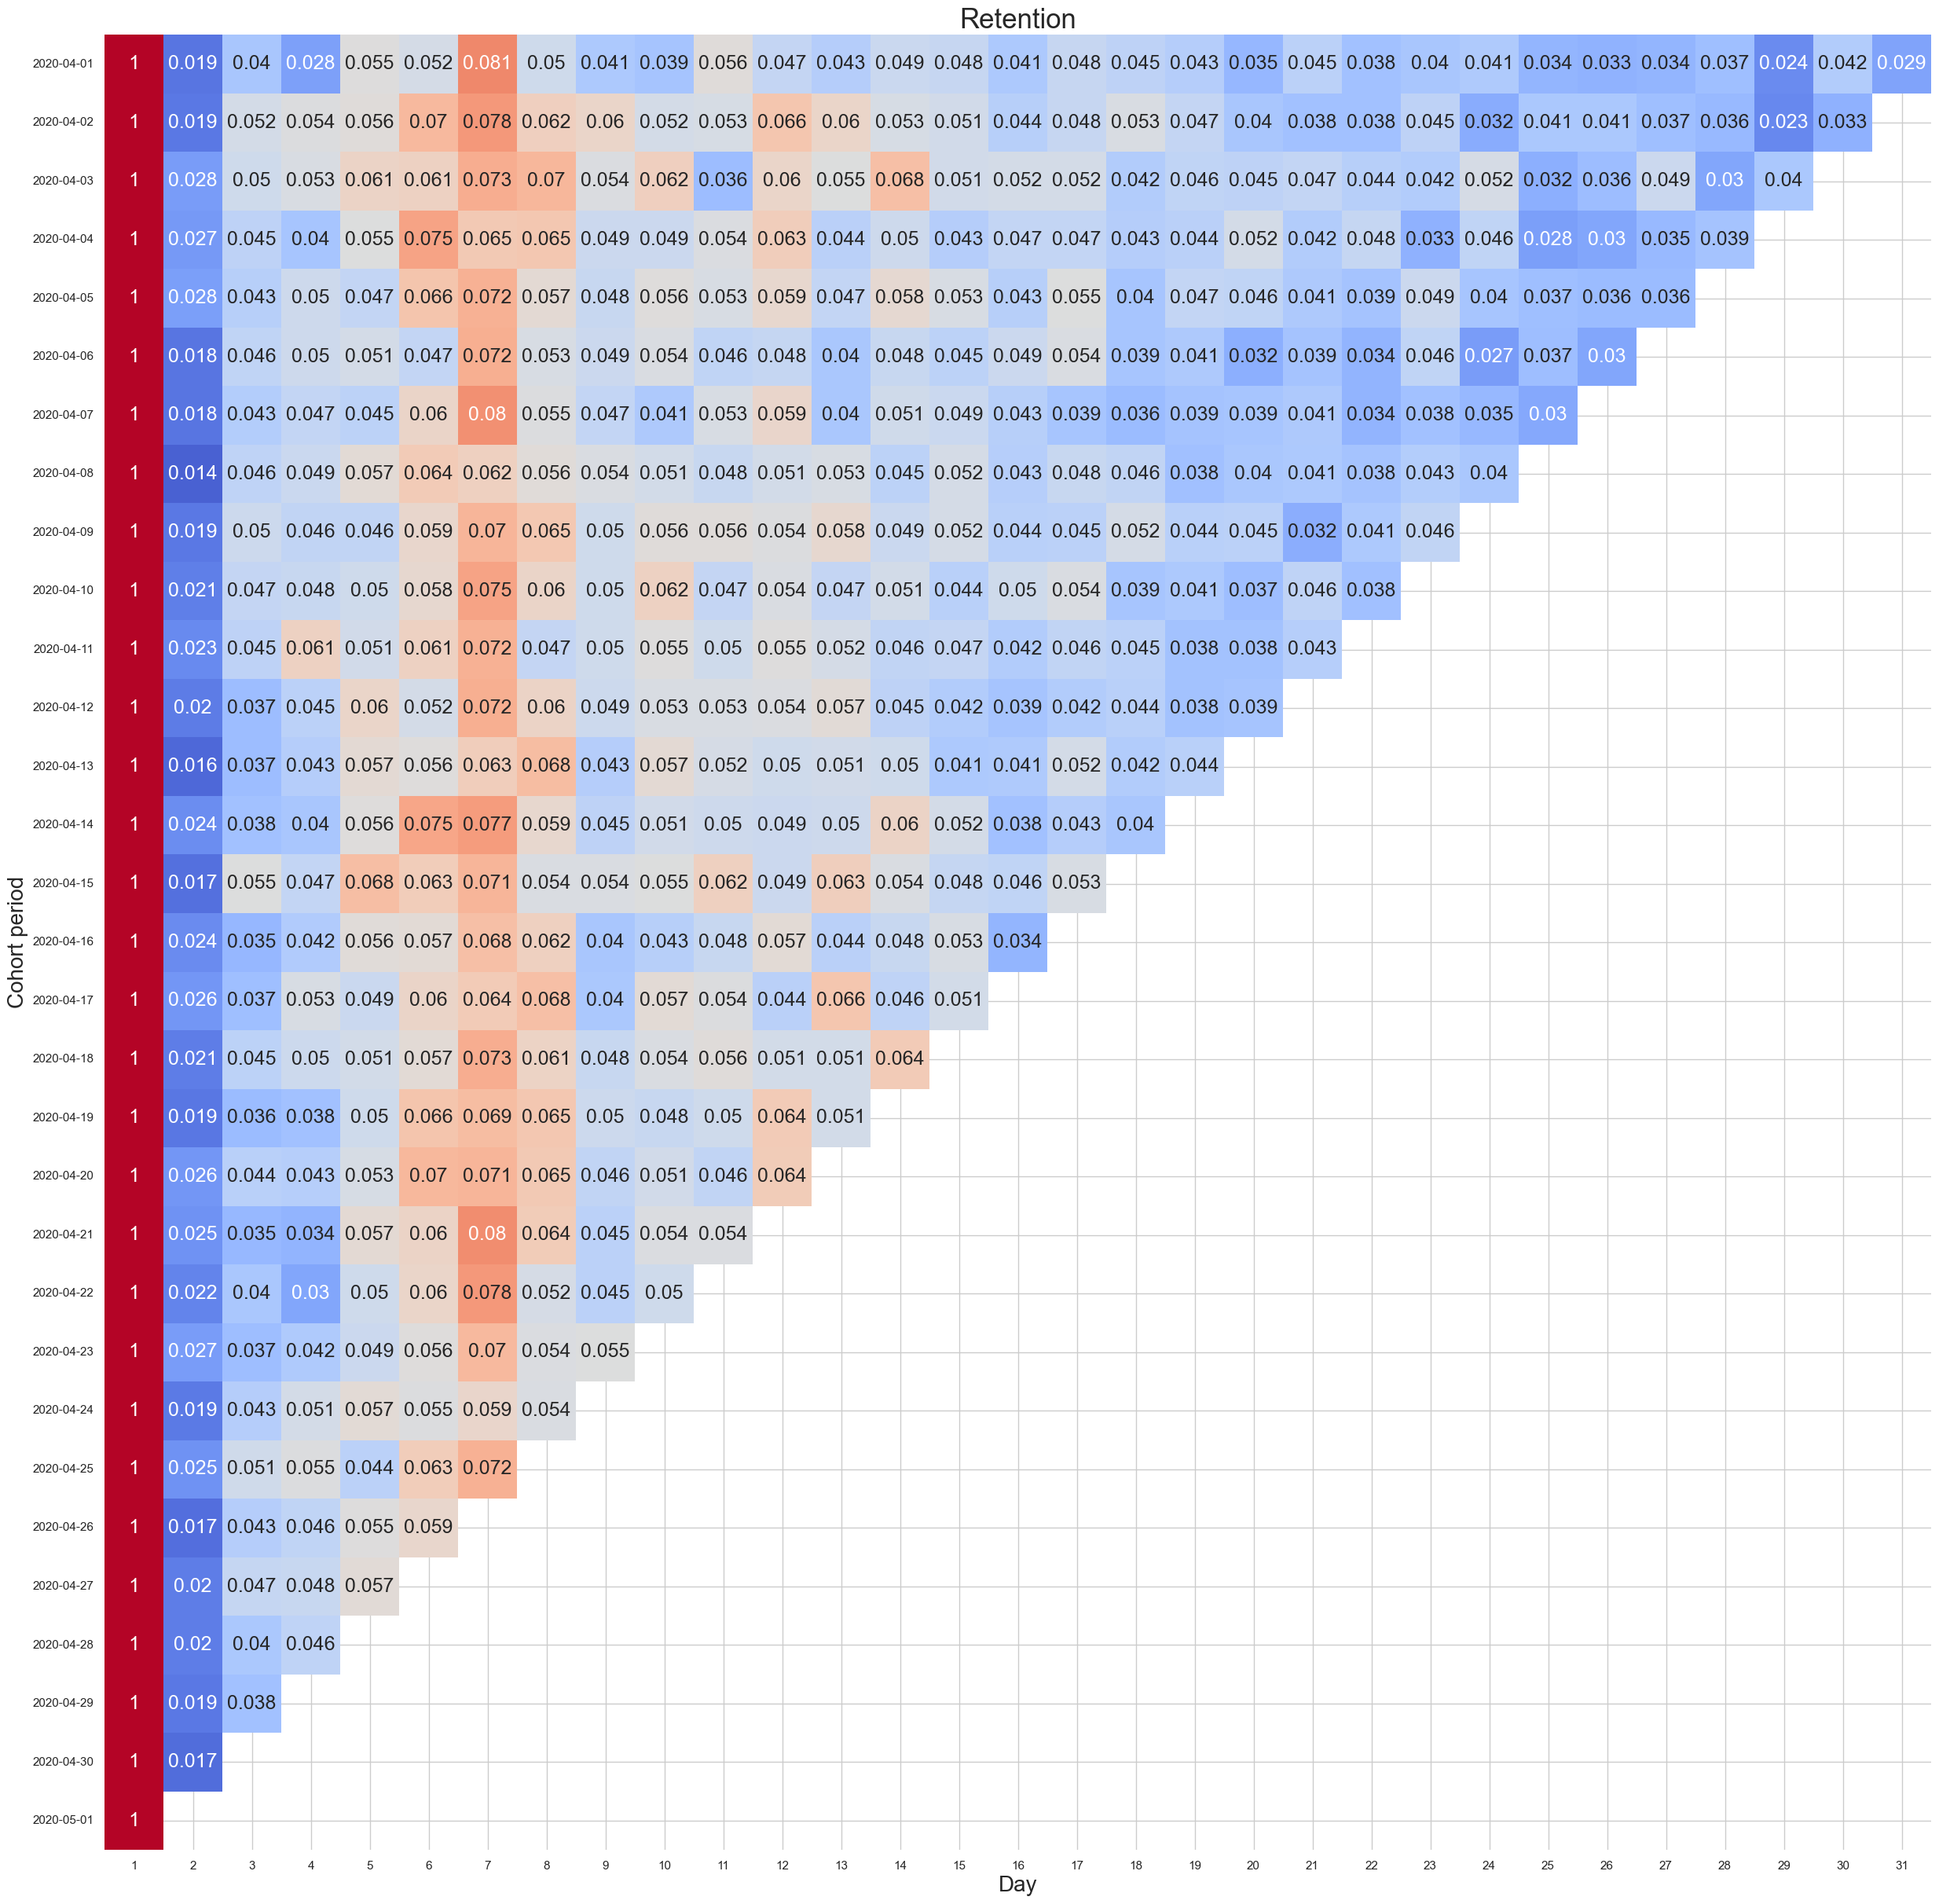

In [31]:
# проверим работу функции, посмотрев на retention за 1 месяц - апрель 2020 года 
get_retention(df, '2020-04-01', 30)

### Задание 2

In [38]:
# считывание файла 
task_2 = open_df('https://disk.yandex.ru/d/SOkIsD5A8xlI7Q')

In [39]:
task_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [40]:
# информация
task_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [41]:
# наличие пустых значений
task_2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [42]:
# наличие дубликатов
task_2.duplicated().sum()

0

In [82]:
task_2.query('testgroup == "a"').describe()

,user_id,revenue,arppu
count,202103.000000,202103.000000,1928.000000
mean,202555.909843,25.413720,0.713651
std,116802.329266,920.768137,2.423912
min,2.000000,0.000000,0.050000
25%,101502.500000,0.000000,0.070000
50%,202988.000000,0.000000,0.080000
75%,303559.000000,0.000000,0.100000
max,404769.000000,37433.000000,10.030000


In [83]:
task_2.query('testgroup == "b"').describe()

,user_id,revenue,arppu
count,202667.000000,202667.000000,1805.000000
mean,202215.564389,26.751287,0.804665
std,116891.926690,287.324162,0.153241
min,1.000000,0.000000,0.540000
25%,100855.500000,0.000000,0.670000
50%,201821.000000,0.000000,0.810000
75%,303602.500000,0.000000,0.930000
max,404770.000000,4000.000000,1.070000


В обеих группах только 25% пользователей совершают покупки, при этом самая большая покупка в контрольной группе в несколько раз превышает максимальную покупку в тестовой (похоже, что это выброс).

In [72]:
# количество пользователей в каждой группе, кто принес какой-либо доход
paying = task_2.query('revenue > 0')\
    .groupby('testgroup', as_index=False)\
    .agg({'user_id' : 'nunique'})\
    .rename(columns={'user_id': 'paying_users'})
paying

,testgroup,paying_users
0,a,1928
1,b,1805


In [58]:
# распределение выручки по группам
groups = task_2.groupby('testgroup', as_index=False)\
    .agg({'user_id' : 'nunique', 'revenue' : 'sum'})
groups

,testgroup,user_id,revenue
0,a,202103,5136189
1,b,202667,5421603


In [74]:
# объединим датафреймы и посчитаем основные метрики
df_with_metrics = groups.merge(paying, on='testgroup')
df_with_metrics['arpu'] = (df_with_metrics['revenue'] / 
                           df_with_metrics['user_id']).round(2)
df_with_metrics['arppu'] = (df_with_metrics['revenue'] / 
                            df_with_metrics['paying_users']).round(2)
df_with_metrics['cr'] = ((df_with_metrics['paying_users'] / 
                            df_with_metrics['user_id']) * 100).round(2)
df_with_metrics

,testgroup,user_id,revenue,paying_users,arpu,arppu,cr
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


Посмотрим на ARPU 

Text(0, 0.5, 'Выручка')

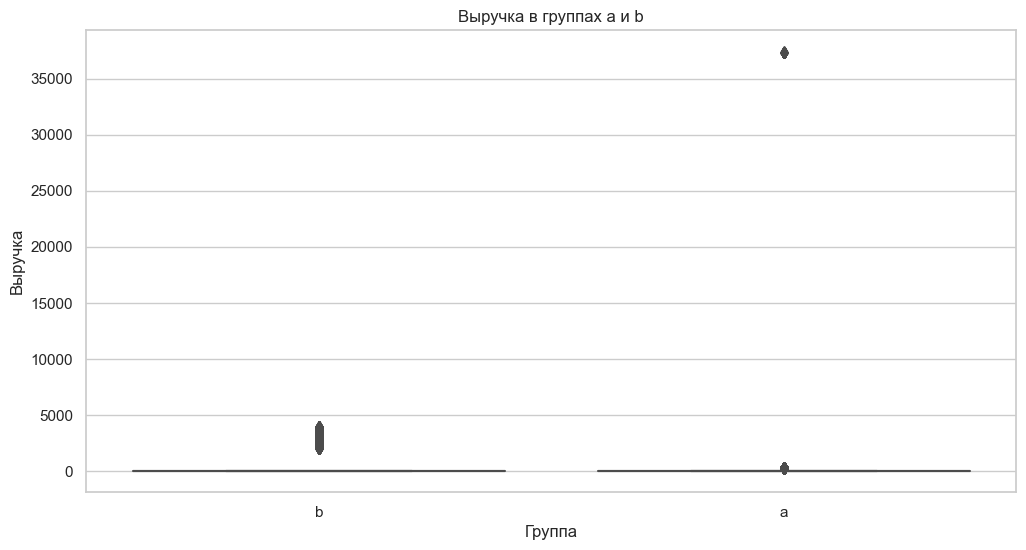

In [45]:
# посмотрим на ящик с усами
sns.boxplot(data=task_2, x="testgroup", y="revenue")

plt.title('Выручка в группах a и b')
plt.xlabel('Группа')
plt.ylabel('Выручка')

Исходя из условия известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. Посмотрим, статистически значимо ли это увеличение:  
**Нулевая гипотеза:** увеличение выручки в тестовой группе статистически не значимо  
**Альтернативная гипотеза:** в тестовой группе стат значимое увеличение выручки

In [50]:
# проверим распределения на нормальность
pg.normality(data=task_2, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
testgroup,,,
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Распределения ненормальные, применим бутстрап для определения того, статистически значима разница в выручке в группах или нет 

In [51]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it=3000, 
    statistic=np.mean, 
    bootstrap_conf_level=0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/3000 [00:00<?, ?it/s]

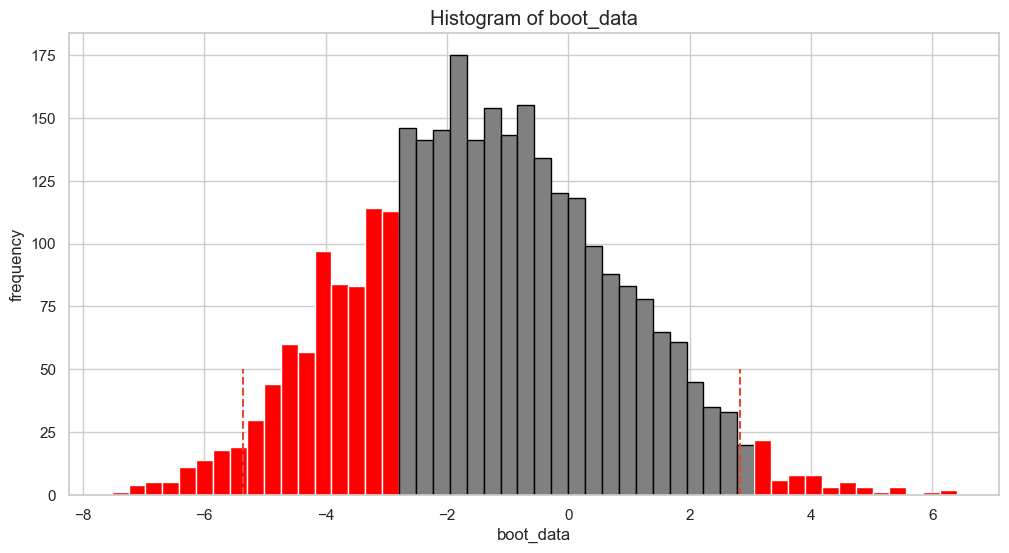

In [52]:
arpu_booted_data = get_bootstrap(task_2.query('testgroup == "a"').revenue,
                                      task_2.query('testgroup == "b"').revenue)

In [54]:
print(f'p_value = {arpu_booted_data["p_value"]}')
print(f'Доверительный интервал: {arpu_booted_data["quants"]}')
if arpu_booted_data["p_value"] <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

p_value = 0.5266541955211674
Доверительный интервал:               0
0.025 -5.368437
0.975  2.832970
Не отклоняем нулевую гипотезу


**Вывод:** Увеличение выручки на 5% в тестовой группе не является статистически значимым

Посмотрим на другую метрику, связанную с доходом - ARPPU

In [69]:
task_2['arppu'] = (task_2.query('revenue > 0').revenue / 
                   task_2.query('revenue > 0').user_id.nunique()).round(2)

  0%|          | 0/3000 [00:00<?, ?it/s]

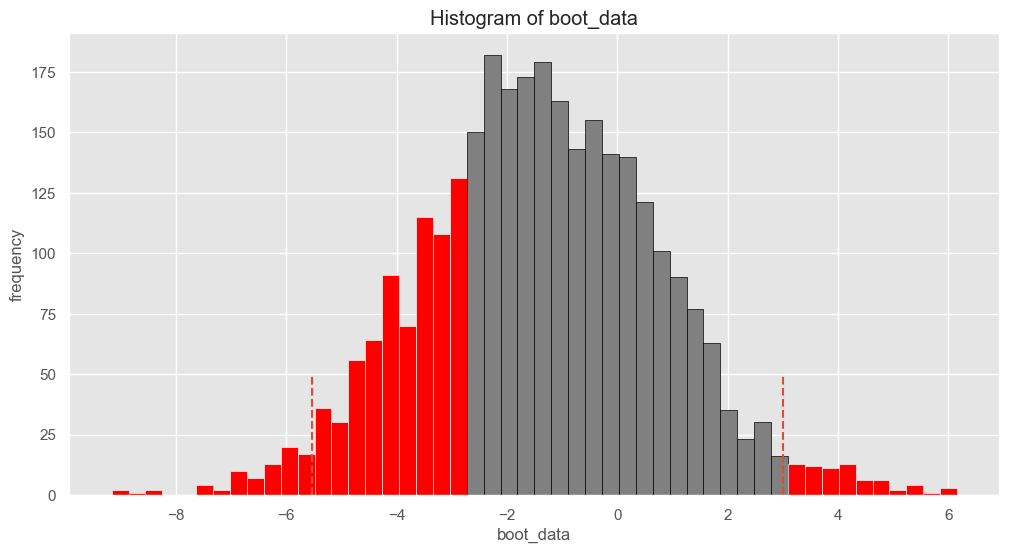

In [75]:
arppu_booted_data = get_bootstrap(task_2.query('testgroup == "a"').revenue,
                                      task_2.query('testgroup == "b"').revenue)

In [76]:
print(f'p_value = {arppu_booted_data["p_value"]}')
print(f'Доверительный интервал: {arppu_booted_data["quants"]}')
if arppu_booted_data["p_value"] <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

p_value = 0.5222440630720594
Доверительный интервал:               0
0.025 -5.523778
0.975  3.010757
Не отклоняем нулевую гипотезу


**Вывод:** Увеличение ARPPU в тестовой группе не является статистически значимым

CR - проверим, значимо ли снижение конверсии в тестовой группе 

In [79]:
for_cr = task_2.groupby('testgroup')\
    .agg(paying_users = ('revenue', lambda x: (x > 0).sum()),
        not_paying_users = ('revenue', lambda x: (x == 0).sum())) 
for_cr

,paying_users,not_paying_users
testgroup,,
a,1928,200175
b,1805,200862


In [80]:
stat, p, dof, expected = chi2_contingency(for_cr)
if p <= 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


**Вывод:** снижение CR в тестовой группе является статистически значимым.  

## Заключение по заданию 2  
В результате исследования результатов А/Б-тестирования пользователей приложения было выявлено:
1) Выручка в тестовой группе больше, однако количество платящих пользователей в ней меньше   
2) Увеличение ARPU в тестовой группе на 5% не является статистически значимым 
3) Выручка с платящего пользователя (ARPPU) в тестовой группе выше, но увеличение также не статистически значимо  
4) Конверсия в тестовой группе статистически значимо ниже, чем в контрольной 

Можно сделать вывод о том, что набор предложений для контрольной группы является более выгодным.
